# Exercise 1: Polynomial Regression and Splines on the Wage Dataset

**Discipline:** Introduction to Statistical Learning

**Objective:**
The objective of this notebook is to fit and compare non-linear regression models to predict `wage` based on `age` using the `Wage` dataset. Two techniques will be explored: polynomial regression and regression splines. The models will be compared using cross-validation to select model complexity and Root Mean Squared Error (RMSE) on a test set to evaluate final performance.

## 1. Load Libraries

In this section, we import the necessary Python libraries for data analysis, modeling, evaluation, and visualization.

Since we are using a **Jupyter notebook**, the `load_ext` and `autoreload` statements can be loaded to enable reloading libraries without having to restart the execution (though they are commented out by default here). We also ensure `matplotlib` plots are displayed inline.

In [1]:
# Automatically reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

To perform the various tasks in this exercise, including data manipulation, model fitting, selection, and evaluation, we import several key Python libraries:

In [2]:
# Importing necessary libraries for data manipulation and analysis
import pandas as pd
import numpy as np
from IPython.display import display

# Importing machine learning libraries
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Exercise Development

This section contains the main analysis, from data loading to model fitting,
comparison, and discussion.

### 2.1. Data Loading and Preparation

**Objective:** Load the `Wage` dataset and prepare it for modeling.

**Process:**
1. Load the `Wage.csv` file from the `datasets` folder.
2. Perform an initial data exploration (`head`, `info`, `describe`).
3. Perform a data cleaning step to ensure the dataset is ready for modeling (e.g., outlier removal, handling missing values, and Normalization if necessary).
4. Split the data into a training set (80%) and a test set (20%) to evaluate the performance of the models on unseen data.

In [3]:
# Load the dataset
try:
    wage_df = pd.read_csv('datasets/Wage.csv')
    # Remove the index column if it exists
    if 'Unnamed: 0' in wage_df.columns:
        wage_df = wage_df.drop('Unnamed: 0', axis=1)

    # Drop the sex and region column as it is not needed for this analysis (have only one unique value)
    wage_df = wage_df.drop(["sex", "region"], axis=1, errors='ignore')
except FileNotFoundError:
    print("Error: Ensure the 'Wage.csv', dataset is in the 'datasets' directory.")
    exit()

First 5 rows of the dataset:


,year,age,maritl,race,education,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Information,1. <=Good,1. Yes,4.318063,75.043154


--------------------------------------------------
Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        3000 non-null   int64  
 1   age         3000 non-null   int64  
 2   maritl      3000 non-null   object 
 3   race        3000 non-null   object 
 4   education   3000 non-null   object 
 5   jobclass    3000 non-null   object 
 6   health      3000 non-null   object 
 7   health_ins  3000 non-null   object 
 8   logwage     3000 non-null   float64
 9   wage        3000 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 234.5+ KB
--------------------------------------------------
Descriptive statistics:


,year,age,logwage,wage
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,2005.791000,42.414667,4.653905,111.703608
std,2.026167,11.542406,0.351753,41.728595
min,2003.000000,18.000000,3.000000,20.085537
25%,2004.000000,33.750000,4.447158,85.383940
50%,2006.000000,42.000000,4.653213,104.921507
75%,2008.000000,51.000000,4.857332,128.680488
max,2009.000000,80.000000,5.763128,318.342430


Descriptive statistics (categorical variables):


,maritl,race,education,jobclass,health,health_ins
count,3000,3000,3000,3000,3000,3000
unique,5,4,5,2,2,2
top,2. Married,1. White,2. HS Grad,1. Industrial,2. >=Very Good,1. Yes
freq,2074,2480,971,1544,2142,2083


--------------------------------------------------
Value counts for 'maritl':


maritl
2. Married          2074
1. Never Married     648
4. Divorced          204
5. Separated          55
3. Widowed            19
Name: count, dtype: int64

Value counts for 'race':


race
1. White    2480
2. Black     293
3. Asian     190
4. Other      37
Name: count, dtype: int64

Value counts for 'education':


education
2. HS Grad            971
4. College Grad       685
3. Some College       650
5. Advanced Degree    426
1. < HS Grad          268
Name: count, dtype: int64

Value counts for 'jobclass':


jobclass
1. Industrial     1544
2. Information    1456
Name: count, dtype: int64

Value counts for 'health':


health
2. >=Very Good    2142
1. <=Good          858
Name: count, dtype: int64

Value counts for 'health_ins':


health_ins
1. Yes    2083
2. No      917
Name: count, dtype: int64

Training set size: 2400 observations
Test set size: 600 observations


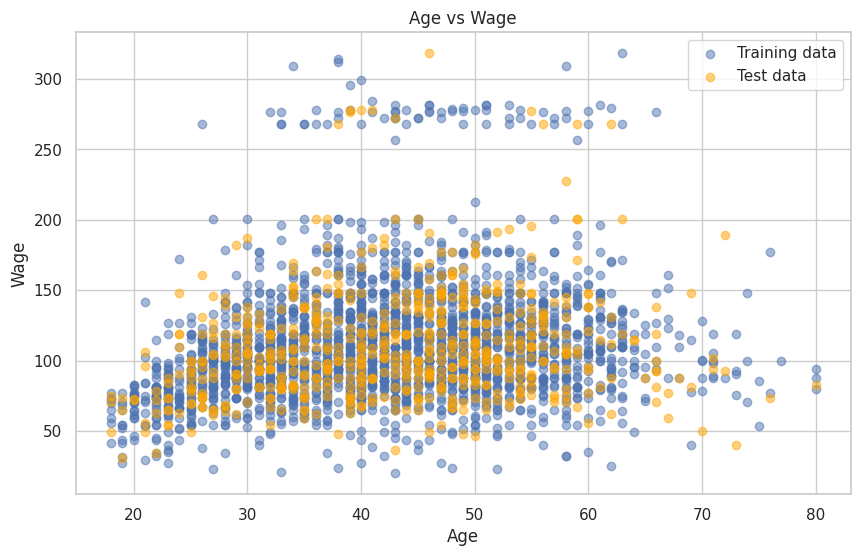

In [4]:
# Initial exploration
print("First 5 rows of the dataset:")
display(wage_df.head())
print("-" * 50)
print("Dataset information:")
wage_df.info()
print("-" * 50)
print("Descriptive statistics:")
display(wage_df.describe())
print("Descriptive statistics (categorical variables):")
display(wage_df.describe(include=['object', 'category']))
print("-" * 50)

# Show value counts for each categorical variable
cat_cols = wage_df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    print(f"Value counts for '{col}':")
    display(wage_df[col].value_counts())

# Define the predictor variable (X) and the target variable (y)
X = wage_df[['age']]
y = wage_df['wage']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)} observations")
print(f"Test set size: {len(X_test)} observations")

# Plot the age vs wage scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train['age'], y_train, alpha=0.5, label='Training data')
plt.scatter(X_test['age'], y_test, alpha=0.5, label='Test data', color='orange')
plt.title('Age vs Wage')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()
plt.show()

Training set size after preprocessing: 2312 observations
Test set size after preprocessing: 578 observations


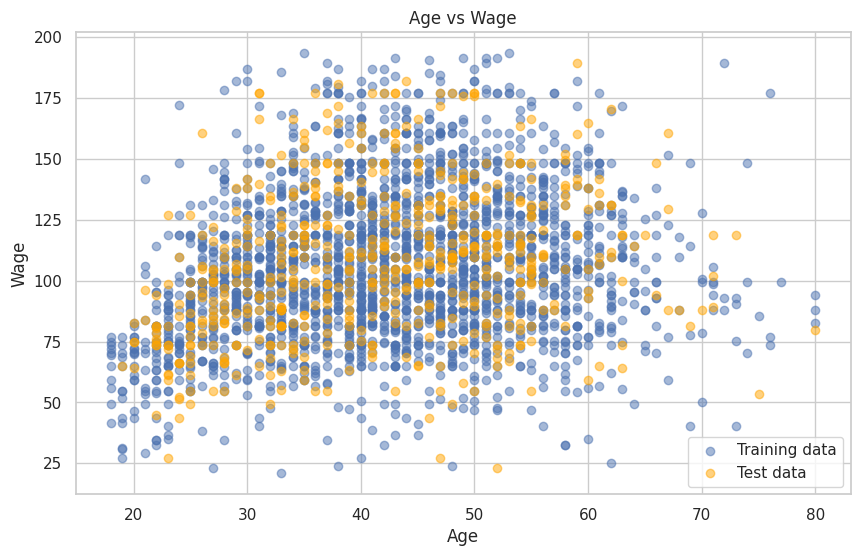

In [5]:
# Preprocessing the data to ensure it is ready for modeling
# Delete rows with missing values
wage_df = wage_df.dropna()

# Drop outliers based on the wage column (e.g., values outside 1.5 * IQR)
factor = 1.5  # Factor for outlier detection
Q1 = wage_df['wage'].quantile(0.25)
Q3 = wage_df['wage'].quantile(0.75)
IQR = Q3 - Q1
wage_df = wage_df[(wage_df['wage'] >= (Q1 - factor * IQR)) & (wage_df['wage'] <= (Q3 + factor * IQR))]

# Re-define the predictor variable (X) and the target variable (y) after preprocessing
X = wage_df[['age']]
y = wage_df['wage']

# Split the preprocessed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size after preprocessing: {len(X_train)} observations")
print(f"Test set size after preprocessing: {len(X_test)} observations")

# Plot the age vs wage scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train['age'], y_train, alpha=0.5, label='Training data')
plt.scatter(X_test['age'], y_test, alpha=0.5, label='Test data', color='orange')
plt.title('Age vs Wage')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()
plt.show()

### 2.2. Polynomial Regression with Cross-Validation

**Objective:** Fit polynomial regression models with degrees from 1 to 5 and use cross-validation to find the optimal degree.

**Process:**
1. Create a loop that iterates through degrees from 1 to 5.
2. In each iteration, use a `scikit-learn` pipeline that first generates polynomial features (`PolynomialFeatures`) and then fits a `LinearRegression` model.
3. Use 10-fold cross-validation (`KFold`) to estimate the model's error on the training set. We will use negative mean squared error as the scoring metric, as `cross_val_score` aims to maximize the score.
4. Plot the cross-validation error (MSE) as a function of the polynomial degree to visualize performance.
5. Identify the degree that minimizes the cross-validation MSE.

Calculating cross-validation error for polynomial regression:
Degree 1: CV MSE = 902.44
Degree 2: CV MSE = 846.21
Degree 3: CV MSE = 840.46
Degree 4: CV MSE = 839.98
Degree 5: CV MSE = 840.55


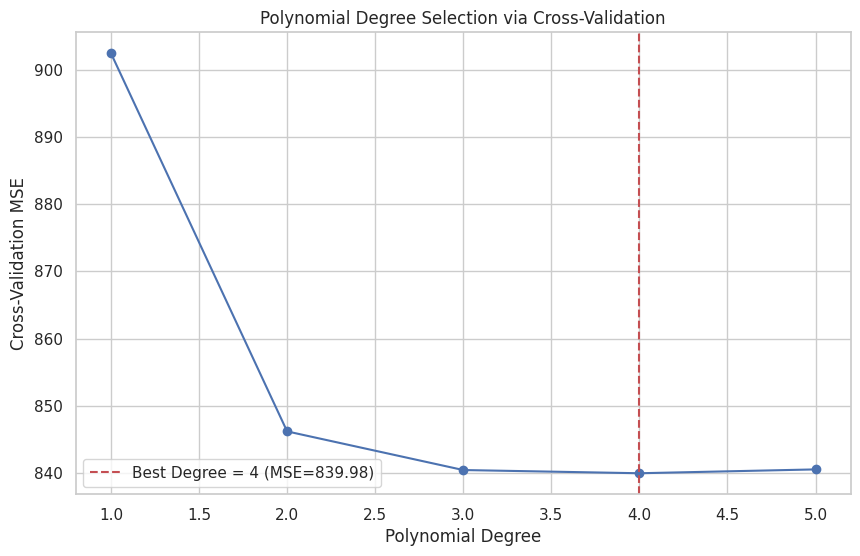

The optimal degree found via cross-validation is: 4


In [6]:
degrees = range(1, 6)
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_errors_poly = []

print("Calculating cross-validation error for polynomial regression:")

for degree in degrees:
    # Create a pipeline: 1. Generate polynomial features, 2. Fit linear model
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression())
    
    # Calculate cross-validation scores (negative mean squared error)
    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    
    # Store the average MSE (converted to positive)
    mse_score = -np.mean(scores)
    cv_errors_poly.append(mse_score)
    print(f"Degree {degree}: CV MSE = {mse_score:.2f}")

# Identify the best degree
best_degree_poly = degrees[np.argmin(cv_errors_poly)]
min_cv_mse_poly = np.min(cv_errors_poly)

# Plot the cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(degrees, cv_errors_poly, marker='o', linestyle='-')
plt.xlabel('Polynomial Degree')
plt.ylabel('Cross-Validation MSE')
plt.title('Polynomial Degree Selection via Cross-Validation')
plt.axvline(x=best_degree_poly, color='r', linestyle='--', label=f'Best Degree = {best_degree_poly} (MSE={min_cv_mse_poly:.2f})')
plt.legend()
plt.grid(True)
plt.show()

print(f"The optimal degree found via cross-validation is: {best_degree_poly}")

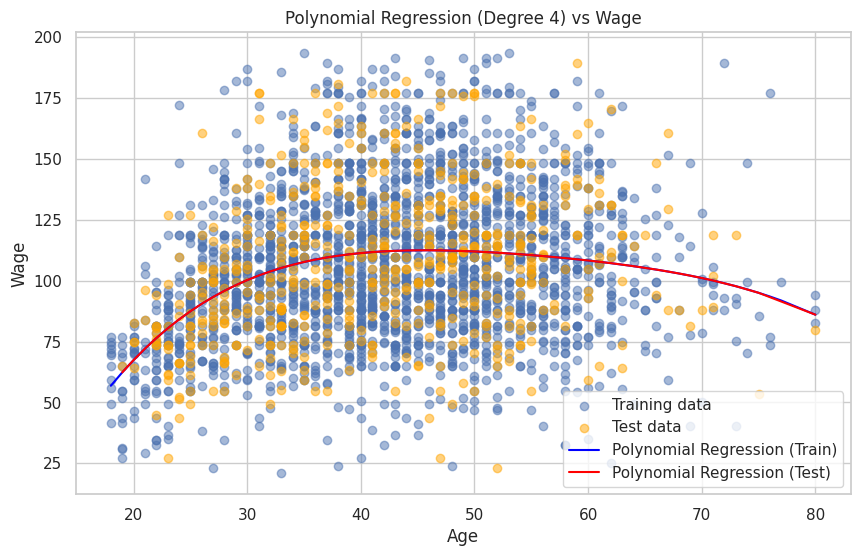

In [7]:
# Plot the line for the best polynomial degree vs the training data
plt.figure(figsize=(10, 6))
# Create the polynomial model with the best degree
best_model_poly = make_pipeline(PolynomialFeatures(degree=best_degree_poly), LinearRegression())
# Fit the model on the training data
best_model_poly.fit(X_train, y_train)
# Generate predictions for the training data
y_train_pred = best_model_poly.predict(X_train)
# Generate predictions for the test data
y_test_pred = best_model_poly.predict(X_test)
# Plot the training data and the polynomial regression line
plt.scatter(X_train['age'], y_train, alpha=0.5, label='Training data')
plt.scatter(X_test['age'], y_test, alpha=0.5, label='Test data', color='orange')

# Organize (X_train, y_train_pred) and (X_test, y_test_pred) in descending order for plotting
X_train_sorted = X_train.sort_values(by='age')
y_train_pred_sorted = y_train_pred[np.argsort(X_train['age'])]
X_test_sorted = X_test.sort_values(by='age')
y_test_pred_sorted = y_test_pred[np.argsort(X_test['age'])]
plt.plot(X_train_sorted['age'], y_train_pred_sorted, color='blue', label='Polynomial Regression (Train)')
plt.plot(X_test_sorted['age'], y_test_pred_sorted, color='red', label='Polynomial Regression (Test)')
plt.title(f'Polynomial Regression (Degree {best_degree_poly}) vs Wage')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()
plt.show()

### 2.3. Regression Splines with Cross-Validation

**Objective:** Fit cubic regression spline models with different numbers of knots (3, 5, and 7) and use cross-validation to find the optimal number of knots.

**Process:**
1. We will manually implement a 10-fold cross-validation loop because we are using `patsy` and `statsmodels`.
2. For each number of knots, we iterate through the folds. In each fold, we define the knot locations based on the fold's *training data only*.
3. We fit an OLS model using `patsy` and `statsmodels` on the fold's training data.
4. We evaluate the model on the fold's validation data and store the MSE.
5. After all folds, we average the MSE for each knot configuration.
6. We plot the CV error vs. the number of knots to find the best configuration.

Calculating cross-validation error for regression splines (using statsmodels):
Number of Knots 3: CV MSE = 843.99
Number of Knots 5: CV MSE = 844.21
Number of Knots 7: CV MSE = 844.07


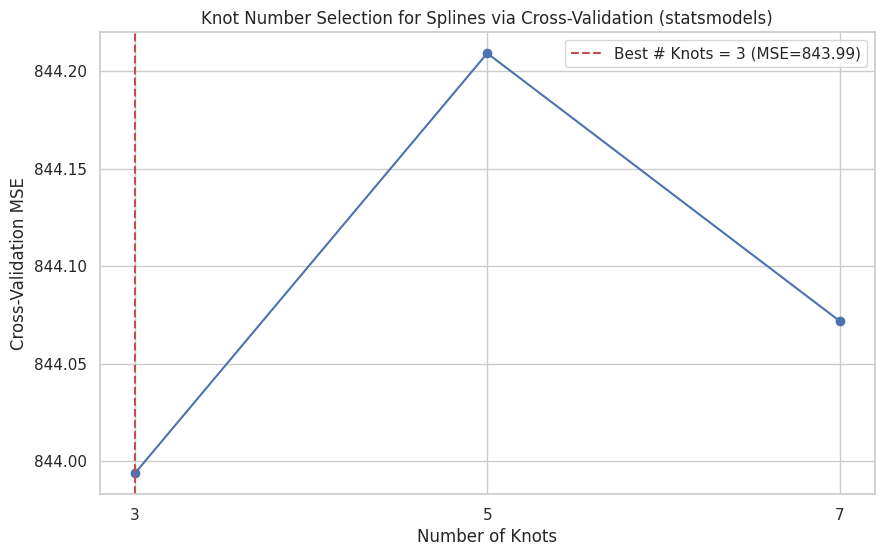

The optimal number of knots found via cross-validation is: 3


In [8]:
# We'll combine them for easier indexing within the cross-validation loop.
train_data_combined = pd.concat([X_train, y_train], axis=1)

num_knots_options = [3, 5, 7]
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
cv_errors_spline = []

print("Calculating cross-validation error for regression splines (using statsmodels):")

for n_knots in num_knots_options:
    # We will store the Mean Squared Error for each of the 10 folds here
    fold_mses = []
    
    # Manual K-Fold loop
    for train_idx, val_idx in kfold.split(train_data_combined):
        # Split data into training/validation for this specific fold
        train_fold = train_data_combined.iloc[train_idx]
        val_fold = train_data_combined.iloc[val_idx]

        # Determine knot placement based ONLY on the training portion of the fold
        # This prevents data leakage from the validation set into the model structure
        knot_percentiles = np.linspace(0, 100, n_knots + 2)[1:-1]
        knots = np.percentile(train_fold['age'], knot_percentiles)

        # Create the design matrix for training using the patsy formula
        # The formula uses B-splines (bs) with the specified knots and a cubic degree
        formula = "wage ~ bs(age, knots=knots, degree=3, include_intercept=False)"
        y_train_fold, X_train_fold_dm = dmatrices(formula, data=train_fold, return_type='dataframe')

        # Fit the GLM (which is equivalent to OLS here) model on the training fold
        fit_fold = sm.GLM(y_train_fold, X_train_fold_dm).fit()

        # Create the design matrix for the validation set using the same formula and knots
        y_val_fold, X_val_fold_dm = dmatrices(formula, data=val_fold, return_type='dataframe')

        # Predict on the validation set and calculate the MSE for this fold
        y_pred_fold = fit_fold.predict(X_val_fold_dm)
        mse = mean_squared_error(y_val_fold, y_pred_fold)
        fold_mses.append(mse)

    # Average the MSEs across all folds for the current number of knots
    mean_mse = np.mean(fold_mses)
    cv_errors_spline.append(mean_mse)
    print(f"Number of Knots {n_knots}: CV MSE = {mean_mse:.2f}")

# Identify the best number of knots from the CV results
best_n_knots = num_knots_options[np.argmin(cv_errors_spline)]
min_cv_mse_spline = np.min(cv_errors_spline)

# Plot the cross-validation results
plt.figure(figsize=(10, 6))
plt.plot(num_knots_options, cv_errors_spline, marker='o', linestyle='-')
plt.xlabel('Number of Knots')
plt.ylabel('Cross-Validation MSE')
plt.title('Knot Number Selection for Splines via Cross-Validation (statsmodels)')
plt.xticks(num_knots_options)
plt.axvline(x=best_n_knots, color='r', linestyle='--', label=f'Best # Knots = {best_n_knots} (MSE={min_cv_mse_spline:.2f})')
plt.legend()
plt.grid(True)
plt.show()

print(f"The optimal number of knots found via cross-validation is: {best_n_knots}")

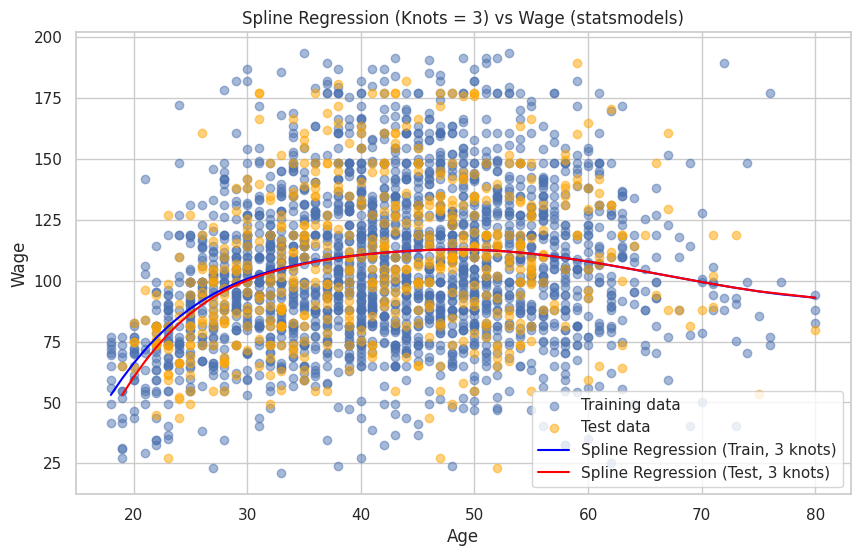

In [9]:
# Plot the line for the best statsmodels spline model vs the data
plt.figure(figsize=(10, 6))

# Define the knots for the best model using the full training set
best_knot_percentiles = np.linspace(0, 100, best_n_knots + 2)[1:-1]
best_knots = np.percentile(X_train['age'], best_knot_percentiles)

# Create the patsy formula for the best model
formula = "wage ~ bs(age, knots=best_knots, degree=3, include_intercept=False)"

# Create the design matrix for the full training data
y_train_dm, X_train_dm = dmatrices(
    formula,
    data=pd.concat([y_train, X_train], axis=1),
    return_type='dataframe'
)

# Fit the final statsmodels spline model
best_model_spline_sm = sm.GLM(y_train_dm, X_train_dm).fit()

# Predictions on the training set
y_train_pred = best_model_spline_sm.predict(X_train_dm)

# Create the design matrix for the test set using the same knots from training
y_test_dm, X_test_dm = dmatrices(
    formula,
    data=pd.concat([y_test, X_test], axis=1),
    return_type='dataframe'
)
# Predictions on the test set
y_test_pred = best_model_spline_sm.predict(X_test_dm)

# Plot the training and test data points
plt.scatter(X_train['age'], y_train, alpha=0.5, label='Training data')
plt.scatter(X_test['age'], y_test, alpha=0.5, label='Test data', color='orange')

# Organize (X_train, y_train_pred) and (X_test, y_test_pred) in ascending order for plotting
# The predictions from patsy/statsmodels keep the original index, so we can sort easily.
train_sort_idx = X_train['age'].argsort()
X_train_sorted = X_train.iloc[train_sort_idx]
y_train_pred_sorted = y_train_pred.iloc[train_sort_idx]

test_sort_idx = X_test['age'].argsort()
X_test_sorted = X_test.iloc[test_sort_idx]
y_test_pred_sorted = y_test_pred.iloc[test_sort_idx]

# Plot the lines connecting the prediction points
plt.plot(X_train_sorted['age'], y_train_pred_sorted, color='blue', label=f'Spline Regression (Train, {best_n_knots} knots)')
plt.plot(X_test_sorted['age'], y_test_pred_sorted, color='red', label=f'Spline Regression (Test, {best_n_knots} knots)')

plt.title(f'Spline Regression (Knots = {best_n_knots}) vs Wage (statsmodels)')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.legend()
plt.show()

### 2.4. Final Model Comparison on the Test Set

**Objective:** Compare the performance of the best polynomial model and the best spline models using the RMSE on the test set.

**Process:**
1. Take the best polynomial model (from its CV) and predict on the test set.
2. For the best spline model (based on CV), predict on the test set.
3. Calculate and compare all RMSE values to determine the model with the best predictive performance on unseen data.

In [16]:
# Final Model Comparison on the Test Set
results = {}

# 1. Polynomial Model Evaluation
# We use the 'poly_model_final' which was already fitted on the full training data
# in a previous step, using the best degree.
print("Evaluating the best polynomial model on the test set:")
print("-" * 50)

# Predict on the test data
y_pred_poly_test = best_model_poly.predict(X_test)
# Calculate RMSE
rmse_poly = np.sqrt(mean_squared_error(y_test, y_pred_poly_test))
results[f'Polynomial (Degree {best_degree_poly})'] = rmse_poly
print(f"RMSE of best polynomial model (degree {best_degree_poly}): {rmse_poly:.2f} \n")


# 2. Spline Model Evaluation
# Now, we fit the single best spline model (using best_n_knots) on the
# full training data and evaluate it on the test set.
print("Evaluating the best spline model on the test set")
print("-" * 50)

# Define knots for the best model using the full training set
best_knot_percentiles = np.linspace(0, 100, best_n_knots + 2)[1:-1]
best_knots = np.percentile(X_train['age'], best_knot_percentiles)

# Create the patsy formula for the best spline model
formula = "wage ~ bs(age, knots=best_knots, degree=3, include_intercept=False)"

# Create the design matrix for the full training data
y_train_dm, X_train_dm = dmatrices(
    formula,
    data=pd.concat([y_train, X_train], axis=1),
    return_type='dataframe'
)

# Fit the final best spline model using statsmodels
best_spline_model_sm = sm.GLM(y_train_dm, X_train_dm).fit()

# Create the design matrix for the test set using the same knots
y_test_dm, X_test_dm = dmatrices(
    formula,
    data=pd.concat([y_test, X_test], axis=1),
    return_type='dataframe'
)

# Predict on the test set and calculate RMSE
y_pred_spline_test = best_spline_model_sm.predict(X_test_dm)
rmse_spline = np.sqrt(mean_squared_error(y_test_dm, y_pred_spline_test))

label = f'Spline ({best_n_knots} knots)'
results[label] = rmse_spline
print(f"RMSE of best spline model ({best_n_knots} knots): {rmse_spline:.2f} \n")


# 3. Comparison
print("Final Comparison: Best Polynomial vs. Best Spline (RMSE on Test Set)")
print("-" * 50)

for model_name, rmse in results.items():
    print(f"{model_name}: {rmse:.2f}")

best_model_name = min(results, key=results.get)
print(f"The best overall model according to the test set RMSE is: {best_model_name}")

Evaluating the best polynomial model on the test set:
--------------------------------------------------
RMSE of best polynomial model (degree 4): 28.35 

Evaluating the best spline model on the test set
--------------------------------------------------
RMSE of best spline model (3 knots): 28.43 

Final Comparison: Best Polynomial vs. Best Spline (RMSE on Test Set)
--------------------------------------------------
Polynomial (Degree 4): 28.35
Spline (3 knots): 28.43
The best overall model according to the test set RMSE is: Polynomial (Degree 4)


### 2.5. Discussion of Interpretability and Flexibility Trade-offs

When comparing polynomial and spline regression, splines generally offer a better trade-off between flexibility and interpretability.

Splines provide a more effective and stable form of flexibility. By adapting locally to the data using knots, they can model complex relationships (like the wage-age curve) without the erratic, global oscillations that high-degree polynomials often produce. This results in a better fit that avoids overfitting.

In terms of interpretability, both models are more complex than simple linear regression. However, a spline is often easier to interpret than a high-degree polynomial. Explaining a relationship in distinct phases (e.g., "wages grow until middle age, then plateau") is more intuitive than trying to make sense of a single, high-order polynomial equation.

Ultimately, the spline model strikes a superior balance. It achieves higher predictive accuracy by being flexible where needed, while its piecewise nature makes it more understandable than an equally flexible but more volatile polynomial model.

## 3. Exercise Conclusions

1. The optimal degree for the polynomial model was 4.

2. The optimal number of knots for the spline model was 3.

3. The spline model performed better on the test set, achieving a lower RMSE.

4. The spline model is the recommended choice for practical use. It delivers higher predictive accuracy and offers a better balance between flexibility and interpretability.

5. Finally, removing outliers during data preprocessing was a crucial step. This ensured that the models were not distorted by extreme values, leading to lower error metrics and more reliable performance on the test set.